# Adaptive Rejection Sampling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from numpy.random import seed

In [2]:
%config InlineBackend.figure_format = "retina"

In [80]:
a, b = 3, 2
p = beta(a=a, b=b)

In [776]:
seed(3141592653)
z0 = p.rvs(3)

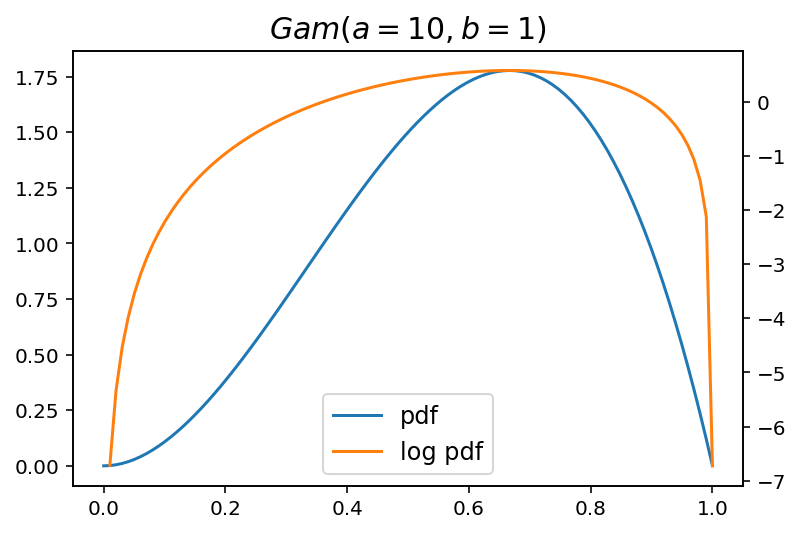

In [777]:
xrange = np.linspace(0, 0.9999, 100)

fig, ax = plt.subplots()
ax2 = ax.twinx()
l1 = ax.plot(xrange, p.pdf(xrange), label="pdf")
l2 = ax2.plot(xrange, p.logpdf(xrange), c="tab:orange", label="log pdf")
l = l1 + l2
labels = [l.get_label() for l in l]
ax.set_title(r"$Gam(a=10,b=1)$", fontsize=15)
plt.legend(l, labels, fontsize=12);

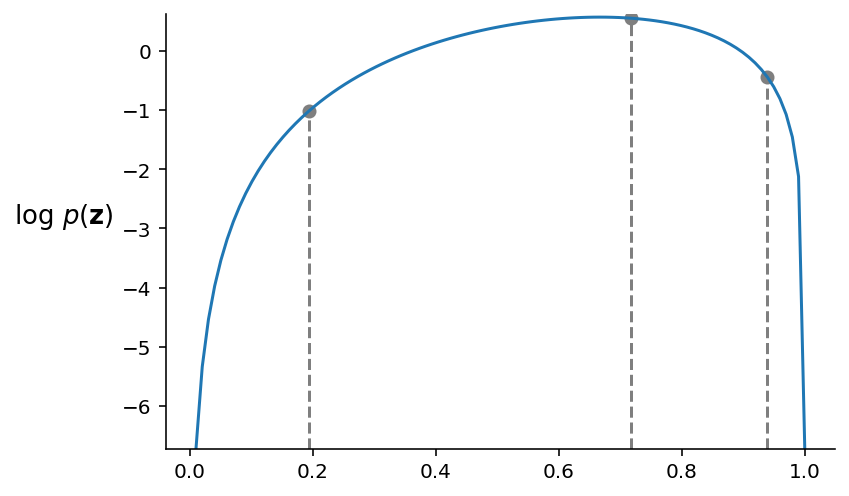

In [778]:
p_logpdf = p.logpdf(xrange)

fig, ax = plt.subplots()
ax.plot(xrange, p_logpdf, label="pdf")
ax.scatter(z0, p.logpdf(z0), color="tab:gray")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

lower_bound = p_logpdf[~np.isinf(p_logpdf)].min()
upper_bound = p_logpdf.max() * 1.1

for z in z0:
    ax.vlines(z, lower_bound, p.logpdf(z), color="tab:gray", linestyle="--")
ax.set_ylim(lower_bound, upper_bound)
ax.set_ylabel(r"$\log \ p({\bf z})$", fontsize=13,
           rotation=0,
           horizontalalignment="right");

In [874]:
def finite_approx(f, x, eps=1e-5):
    return (f(x + eps) - f(x - eps)) / (2 * eps)

In [876]:
z = np.sort(z0)
lambda_n = finite_approx(p.logpdf, z)
lambda_n

array([  9.10271003,  -0.76087912, -14.22522469])

In [877]:
def compute_intersect(x1, x2, f, eps=1e-5):
    """
    Compute the x-value that intersects two lines
    of the form
    yi = li * (x - xi) + f(zi)
    
    Parameters
    ----------
    x1, x2: float
        The tangent points
    f: function
        the target function
    """
    l1 = finite_approx(f, x1, eps=eps)
    l2 = finite_approx(f, x2, eps=eps)
    den = (l1 - l2)
    num = f(x2) - f(x1) + l1 * x1 - l2 * x2
    return num / den


def tangent_line(zi, z1, f, eps=1e-5):
    return finite_approx(f, z1, eps=eps) * (zi - z1) + f(z1)


def f_approx_gen(z, f, eps=1e-5):
    """
    Parameters
    ----------
    z: np.array
        evaluation points
    slopes: np.array
        slopes of approximating lines
    f: function
    """
    z = np.sort(z)
    slopes = finite_approx(f, z, eps=eps)
    @np.vectorize
    def f_approx(zi):
        if zi <= z.min():
            return tangent_line(zi, z[0], f, eps)
        elif zi >= z.max():
            return tangent_line(zi, z[-1], f, eps)
        else:
            # find intermediate points
            z1 = z[zi >= z].max()
            z2 = z[zi <= z].min()
            
            intersect = compute_intersect(z1, z2, f)

            if zi < intersect:
                return tangent_line(zi, z1, f, eps)
            else:
                return tangent_line(zi, z2, f, eps)
    
    return f_approx

In [878]:
zrange = np.linspace(0, 1, 100)

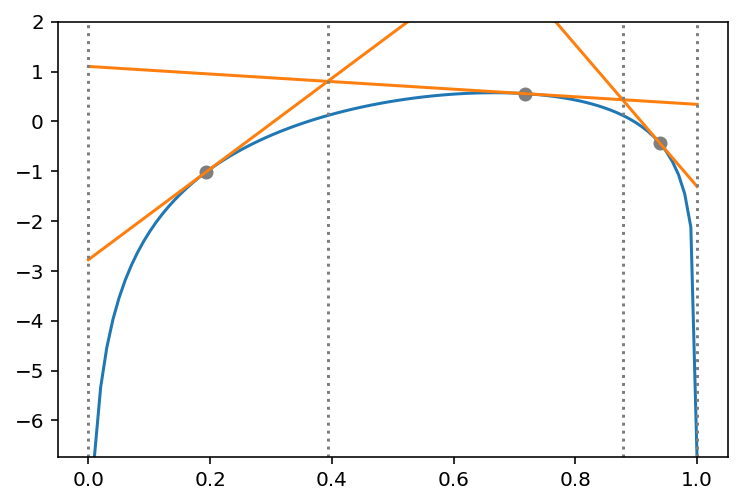

In [879]:
intersections = [compute_intersect(z1, z2, p.logpdf) for z1, z2 in zip(z[:-1], z[1:])]

plt.plot(xrange, p_logpdf, label="pdf")
plt.scatter(z0, p.logpdf(z0), color="tab:gray")

for zi, li in zip(z, lambda_n):
    y1 = (zrange - zi) * li + p.logpdf(zi)
    plt.plot(zrange, y1, c="tab:orange")
    
for x_intersect in [0] + intersections + [1]:
    plt.axvline(x=x_intersect, c="tab:gray", linestyle="dotted")
plt.ylim(lower_bound, 2);

Our first log-approximation is given by

$$
    \log\tilde q(z) = \log p(z_n) + \lambda_n (z - z_n)
$$

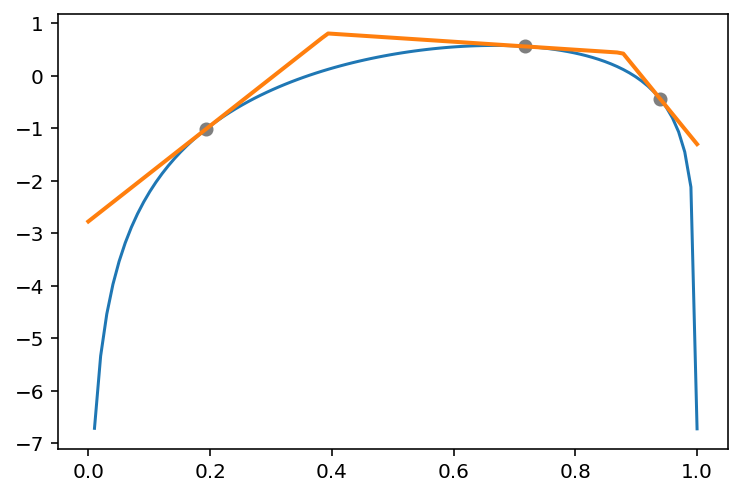

In [880]:
f_approx = f_approx_gen(z, p.logpdf)
plt.plot(xrange, p_logpdf, label="pdf")
plt.plot(xrange, f_approx(xrange), linewidth=2)
plt.scatter(z0, p.logpdf(z0), color="tab:gray")

With non-normalized probabilistic approximation given by

$$
    \tilde q(z) = p(z_n)\exp\big(\lambda_n (z - z_n)\big)
$$

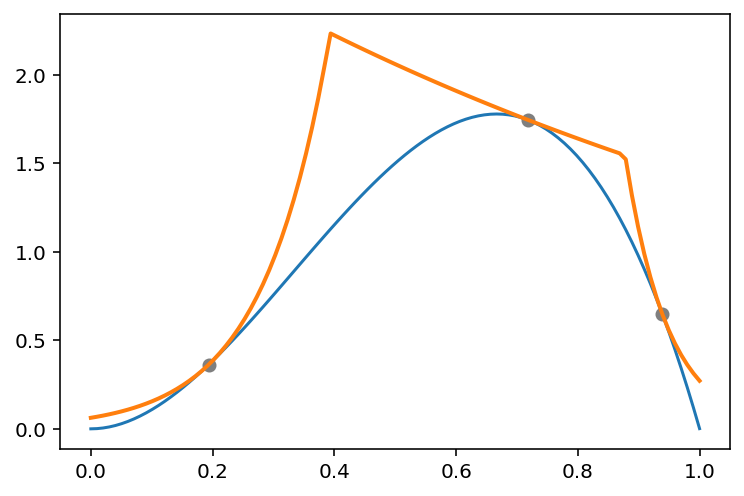

In [881]:
log_f_approx = f_approx_gen(z, p.logpdf)
def f_approx(x): return np.exp(log_f_approx(x))
plt.plot(xrange, p.pdf(xrange), label="pdf")
plt.plot(xrange, f_approx(xrange), linewidth=2)
plt.scatter(z0, p.pdf(z0), color="tab:gray")

The normalization coefficient $I$ is given by

$$
    I = \sum_{n=1}^{N_0}p(z_n)\int_{i_{n-1}}^{i^{n}} \exp\big(\lambda_n (z - z_n)\big) dz
$$

where
* $i_{n-1}$ is the lower bound for the part-function defined over the $n$-th observation: either an intersection point or lower bound of the domain.
* $i_n$ is the upper bound for the part-function defined over the $n$-th observation: either an intersection point or the upper bound of the domain.

In [882]:
from scipy.integrate import quad

In [883]:
quad(f_approx, 0, intersections[0])

(0.23852225944672836, 2.6481290432337306e-15)

In [884]:
l1 = lambda_n[0]
(f_approx(intersections[0]) - f_approx(0)) / l1

0.23852225944672847

In [885]:
quad(f_approx, intersections[0], intersections[1])

(0.9048232703888462, 1.0045556280023307e-14)

In [886]:
l1 = lambda_n[1]
(f_approx(intersections[1]) - f_approx(intersections[0])) / l1

0.9048232703888461

In [887]:
Z_norm, err = quad(f_approx, 0, 1)
def q_dist(x): return f_approx(x) / Z_norm

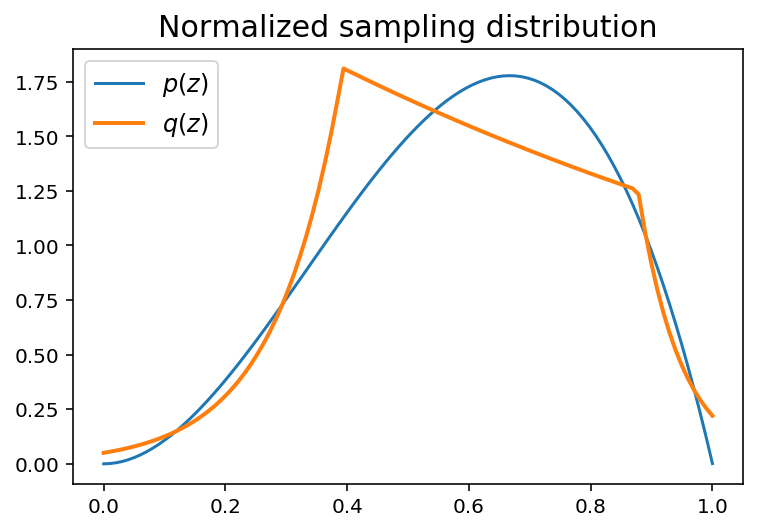

In [888]:
plt.plot(xrange, p.pdf(xrange), label="$p(z)$")
plt.plot(xrange, q_dist(xrange), linewidth=2, label="$q(z)$")
plt.legend(fontsize=12)
plt.title("Normalized sampling distribution", fontsize=15);

In [889]:
%%time
zrange = np.linspace(0, 1, 100)
empirical_cdf = np.empty_like(zrange)

for ix, zval in enumerate(zrange):
    qi = quad(q_dist, 0, zval)[0]
    empirical_cdf[ix] = qi

CPU times: user 1min 37s, sys: 1.1 s, total: 1min 38s
Wall time: 1min 38s


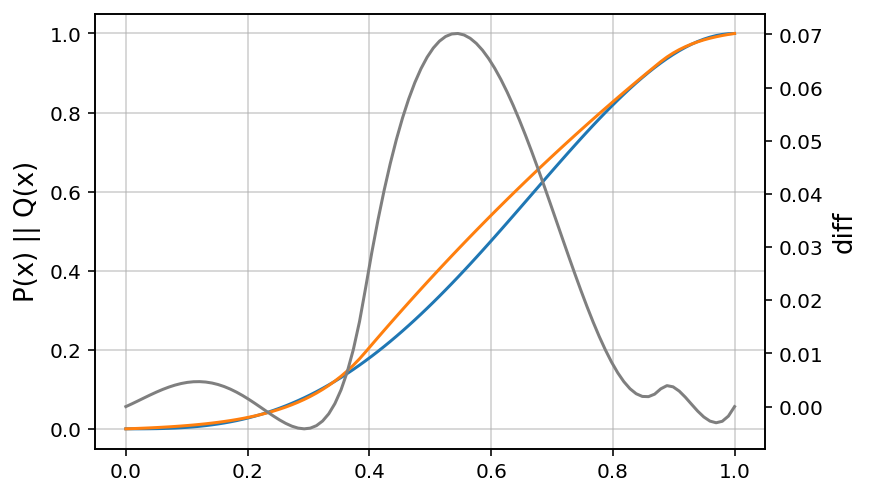

In [890]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(zrange, p.cdf(zrange))
ax.plot(zrange, empirical_cdf)
ax2.plot(zrange, empirical_cdf - p.cdf(zrange), c="tab:gray")
ax.grid(alpha=0.6)
ax2.set_ylabel("diff", fontsize=13);
ax.set_ylabel("P(x) || Q(x)", fontsize=13);

## Sampling from $q(z)$

if $y\sim\text{U}(0, 1)$, then

$$
z = \frac{1}{\lambda_n}\log\left(\frac{\lambda_n Z_q(y - c)}{p(z_n)} + \exp\big((\lambda_n (i_{n-1} - z_n)\big)\right)
$$

Where
* $c = P(z \leq i_{n-1})$

In [794]:
from numpy.random import rand

In [891]:
def q_cdf_nonorm(x, f, z_obs, lb, ub):
    """
    Parameters
    ----------
    intersections: list
        Set of intersecting points
    lb: float
        Lower bound of the distribution
    ub: float
        Upper bound of the distribution
    """
    intersections = [compute_intersect(z1, z2, p.logpdf) for z1, z2 in zip(z_obs[:-1], z_obs[1:])]
    regions = np.array([lb] + intersections + [ub])
    
    if x <= lb:
        return 0
    else:
        I = 0
        bounds = regions[x >= regions]
        pair_bounds = list(zip(bounds[:-1], bounds[1:]))
        for ix, (b0, b1) in enumerate(pair_bounds):
            ln = finite_approx(p.logpdf, z[ix])
            I += (f(b1) - f(b0)) / ln
        if len(pair_bounds) == 0:
            ix = -1
        if x < ub:
            ln = finite_approx(p.logpdf, z[ix + 1])
            I += (f(x) - f(bounds[-1])) / ln
        return I

In [892]:
Z_norm = q_cdf_nonorm(1, f_approx, z, 0, 1)

In [893]:
def make_q_cdf(f, z_obs, lb, ub):
    Z_norm = q_cdf_nonorm(ub, f, z_obs, lb, ub)
    def q(x):
        return q_cdf_nonorm(x, f, z_obs, lb, ub) / Z_norm
    return q
    
q_cdf = make_q_cdf(f_approx, z, 0, 1)

In [894]:
cdf = [q_cdf(zi) for zi in zrange]

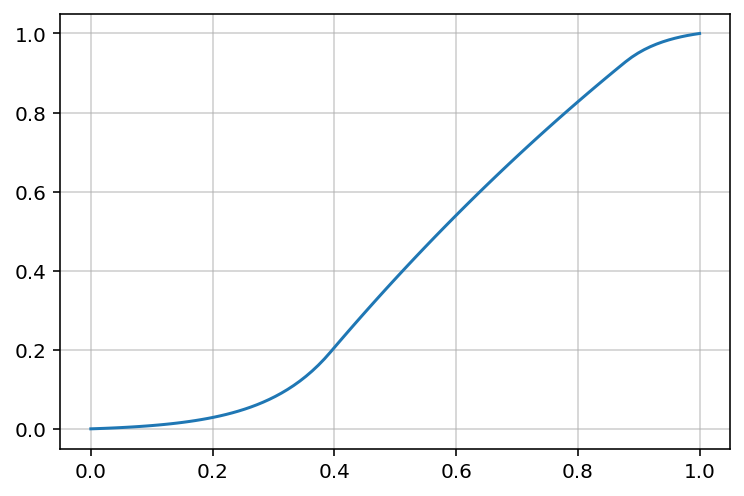

In [895]:
plt.plot(zrange, cdf)
plt.grid(alpha=0.6)

In [896]:
from numpy.random import rand, seed, random_sample
import seaborn as sns

In [897]:
lb, ub = 0, 1
regions = np.array([lb] + intersections + [ub])

In [905]:
def q_inv(y, z_obs, logp, regions):
    """
    Parameters
    ----------
    y: float
        random variable from a U(0, 1) distribution
    """
    i0 = regions[y >= regions].max()
    c = q_cdf(i0)

    if y <= z.min():
        zn = z[0]
    elif y >= z.max():
        zn = z[-1]
    else:
        # find intermediate points
        z1 = z[y >= z].max()
        z2 = z[y <= z].min()

        intersect = compute_intersect(z1, z2, logp)

        if y < intersect:
            zn = z1
        else:
            zn = z2

    ln = finite_approx(p.logpdf, zn)
    z_samp = np.log(ln * Z_norm * (y - c) / p.pdf(zn) + np.exp(ln * (i0 - zn))) / ln + zn
    return z_samp

In [907]:
yvals = random_sample(5_000)
z_samples = []
for y in yvals:
    z_samp = q_inv(y, z, p.logpdf, regions)
    z_samples.append(z_samp)

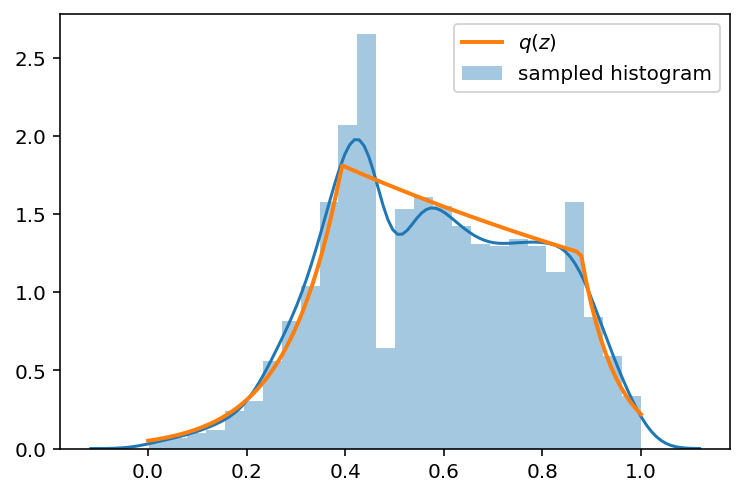

In [908]:
sns.distplot(z_samples, label="sampled histogram")
plt.plot(xrange, q_dist(xrange), linewidth=2, label="$q(z)$")
plt.legend();